<a href="https://colab.research.google.com/github/jhubar/sentiment_analysis/blob/main/movieReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -r transformers
!git clone https://github.com/huggingface/transformers.git
!cd tranformers
!pip install -q ./transformers


Cloning into 'transformers'...
remote: Enumerating objects: 100468, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 100468 (delta 155), reused 228 (delta 97), pack-reused 100124
Receiving objects: 100% (100468/100468), 94.02 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (74017/74017), done.
/bin/bash: line 0: cd: tranformers: No such file or directory
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import shutil
import time 
import pandas as pd 
import requests 
import torch 
import torch.nn.functional as F
import transformers 
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/movie_review_train.tsv", sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
size_of_dataset = len(df)
len_train = int(0.7 * size_of_dataset)

len_val = len_train+int(0.2 * size_of_dataset)
len_val


22500

In [77]:
train_texts = df.iloc[:len_train]['review'].values
train_labels = df.iloc[:len_train]['sentiment'].values

valid_texts = df.iloc[len_train:len_val]['review'].values
valid_labels = df.iloc[len_train:len_val]['sentiment'].values

test_texts = df.iloc[len_val:]['review'].values
test_labels = df.iloc[len_val:]['sentiment'].values

In [78]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(list(train_texts),truncation = True, padding = True)
valid_encodings = tokenizer(list(valid_texts),truncation = True, padding = True)
test_encodings = tokenizer(list(test_texts),truncation = True, padding = True)

In [79]:
class IMDbDataset(torch.utils.data.Dataset):
  def __init__(self,encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx):
    item = {key:torch.tensor(val[idx]) for key ,val in self.encodings.items()}
    item['labels']= torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)
  
train_dataset = IMDbDataset(train_encodings,train_labels)
valid_dataset = IMDbDataset(valid_encodings,valid_labels)
test_dataset = IMDbDataset(test_encodings,test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16, shuffle=True)
valide_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=16, shuffle=True)


In [80]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
model.to(device)
model.train()
optim = torch.optim.Adam(model.parameters(),lr=5e-5)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [81]:
def compute_accuracy(model,data_loder,device):
  with torch.no_grad():
    correct_pred, num_examples = 0, 0
    for batch_idx, batch in enumerate(data_loder):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids,attention_mask =attention_mask)
      logits = outputs['logits']
      predicted_labels = torch.argmax(logits,1)
      num_examples += labels.size(0)
      correct_pred += (predicted_labels == labels).sum()
      return correct_pred.float()/num_examples * 100



In [82]:
start_time = time.time()
train_accs = []
val_accs = []
train_loss = []
val_loss = []
val_iterator = iter(valide_loader)
val_batch_idx = 0
num_epochs = 4
for epoch in range(num_epochs):
  
  for batch_idx, batch in enumerate(train_loader):
    model.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids,attention_mask=attention_mask,labels=labels)

    loss,logits = outputs['loss'], outputs['logits']

    optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optim.step()
    train_loss.append(loss)


    if not batch_idx % 250:
      print(f'Epoch:{epoch+1/num_epochs}'f' | Batch'f'{batch_idx}/'f'{len(train_loader)} |'f'Loss:{loss}')
      train_acc = compute_accuracy(model,train_loader,device)
      train_accs.append(train_acc)
    
    if val_batch_idx >= len(val_iterator):
        val_iterator = iter(valide_loader)
        val_batch_idx = 0
    val_batch_idx += 1
    model.eval()

    with torch.no_grad():
      batch = next(val_iterator)
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids,attention_mask=attention_mask,labels=labels)
      val_acc = compute_accuracy(model,valide_loader,device)
      val_accs.append(val_acc)
      val_loss.append(outputs['loss'].item())
    if not batch_idx % 250:
      print(f'Trainning accuracy:' f'{train_acc}%' f'\n Valid accuracy:'f'{val_acc}%')

      print(f'Time elapsed: {(time.time() - start_time)/60} min')

print(f'Total Training time: {(time.time() - start_time)/60} min')
print(f'Test Accurcay: {compute_accuracy(model,test_loader,device)}%')





Epoch:0.25 | Batch0/1094 |Loss:0.7027884125709534
Trainning accuracy:43.75%
 Valid accuracy:56.25%
Time elapsed: 0.03145126501719157 min
Epoch:0.25 | Batch250/1094 |Loss:0.06761240214109421
Trainning accuracy:87.5%
 Valid accuracy:93.75%
Time elapsed: 2.897786486148834 min
Epoch:0.25 | Batch500/1094 |Loss:0.3745127320289612
Trainning accuracy:100.0%
 Valid accuracy:100.0%
Time elapsed: 5.762811271349589 min
Epoch:0.25 | Batch750/1094 |Loss:0.4044204354286194
Trainning accuracy:87.5%
 Valid accuracy:75.0%
Time elapsed: 8.628315011660257 min
Epoch:0.25 | Batch1000/1094 |Loss:0.3062245547771454
Trainning accuracy:93.75%
 Valid accuracy:87.5%
Time elapsed: 11.494827103614806 min
Epoch:1.25 | Batch0/1094 |Loss:0.08395697921514511
Trainning accuracy:93.75%
 Valid accuracy:87.5%
Time elapsed: 12.572999389966329 min
Epoch:1.25 | Batch250/1094 |Loss:0.06503621488809586
Trainning accuracy:87.5%
 Valid accuracy:93.75%
Time elapsed: 15.43905637661616 min
Epoch:1.25 | Batch500/1094 |Loss:0.04742624

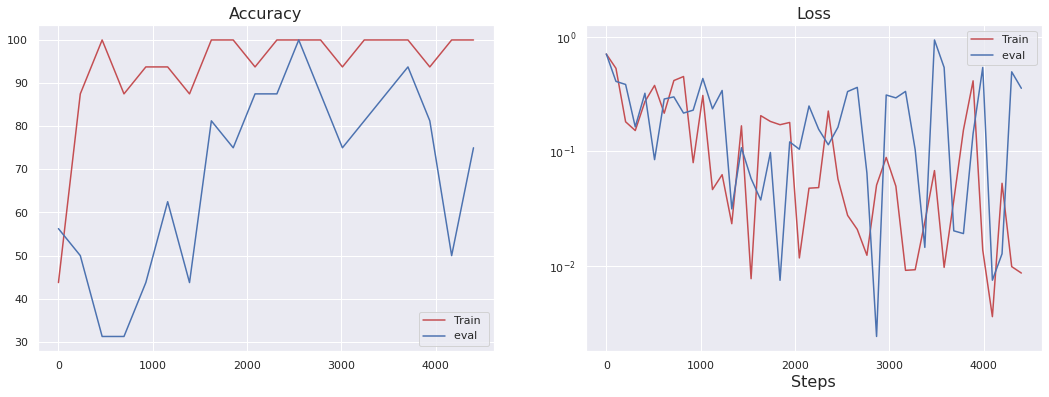

In [83]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

A_train = []
A_eval = []
A_train_loss = []
A_eval_loss = []
sns.set_palette("Paired")

sns.set()
# print(train_loss)
for i in range(0,len(train_loss),100):
  A_train_loss.append(train_loss[i].item())
  A_eval_loss.append(val_loss[i])

for i in range(len(train_accs)):
  A_train.append(train_accs[i].item())
  A_eval.append(val_accs[i].item())




fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(18,6))
N=  44
x = np.linspace(0,4400 , N, endpoint=True)
x1 = np.linspace(0,4400 , 20, endpoint=True)

ax1.plot(x1,A_train,color="r",label="Train ")
ax1.plot(x1,A_eval,color="b",label="eval ")
ax1.legend()
ax1.set_title('Accuracy',fontsize=16)
ax2.plot(x,A_train_loss,color="r",label="Train ")
ax2.plot(x,A_eval_loss,color="b",label="eval ")
ax2.set_yscale('log')
ax2.set_xlabel('Steps',fontsize=16)
ax2.set_title('Loss',fontsize=16)
ax2.legend()

plt.show()
